# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#Импортируем библиотеки
import re
import nltk
import spacy
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')
nlp = spacy.load('en_core_web_sm')

In [2]:
#Загружаем данные в переменную df
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
#Знакомимся с данными
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
64209,64276,Spoken article? \n\nIf I read the whole thing ...,0
114296,114394,}}\n{{onlinesource\n| small = yes\n| title = O...,0
44145,44198,June 2010 \n Please stop. If you continue to i...,0
49407,49462,"I've completed fleshing out the cites, attempt...",0
21135,21155,"""::*Just once, excuse me. talk \n\n""",0


In [4]:
#Проверим наличие дубликатов
df.duplicated().sum()

0

Дубликатов нет, пропусков тоже. А вот столбец `Unnamed: 0`, похоже, лишний - удалим его.

In [5]:
#Удаляем столбец
df = df.drop('Unnamed: 0', axis=1)

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
#Проверяем значения столбца
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [7]:
#Пишем функцию для очистки текста
def clean(text):
    text = text.lower()
    text = re.sub(r'(?:\n|\r)', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#\w+',' ', text)
    text = re.sub(r'@\w+',' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'[^a-zA-Z ]+', '', text).strip()    
    return text

In [8]:
#Чистим и проверяем
df['clean'] = df['text'].apply(clean)
df['clean'].head(10)

0    explanation why the edits made under my userna...
1    d aww  he matches this background colour i m s...
2    hey man  i m really not trying to edit war  it...
3    more i can t make any real suggestions on impr...
4    you  sir  are my hero  any chance you remember...
5    congratulations from me as well  use the tools...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word  nonsense  was offensive to ...
9    alignment on this subject and which are contra...
Name: clean, dtype: object

In [10]:
#Пишем функцию для лемматизации через spaCy
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [11]:
# Применяем функцию и проверяем
df['lemma'] = df['clean'].apply(lemmatize_text)
df.sample(10)

,text,toxic,clean,lemma
131683,"Oh, it's worse than rants, it's a rampage of i...",0,oh it s worse than rants it s a rampage of i...,oh it s bad than rant it s a rampage of ir...
5274,This is my first experience typing in Wikipedia.,0,this is my first experience typing in wikipedia,this be my first experience type in wikipedia
32754,"""== Your edit to Talk:China. ==\n\nPlease stop...",0,your edit to talk china please stop if y...,your edit to talk china please stop if...
57227,"""\n\n I'm going to have to pick up the cluesti...",0,i m going to have to pick up the cluestick ins...,I m go to have to pick up the cluestick instea...
130174,Misc Activities \n\nBETA\nBeta is a business a...,0,misc activities beta beta is a business acad...,misc activity beta beta be a business acade...
153803,Wasn't meant as a gibe. Serious point. Love ...,0,wasn t meant as a gibe serious point love ...,wasn t mean as a gibe serious point love...
152837,"""\n\nI am sorry but the text you are adding to...",0,i am sorry but the text you are adding to the ...,I be sorry but the text you be add to the arti...
48749,"""\n\nI'd have to disagree, we've had this exac...",0,i d have to disagree we ve had this exact dis...,I d have to disagree we ve have this exact d...
39258,Please stop. If you continue to vandalize Wiki...,0,please stop if you continue to vandalize wiki...,please stop if you continue to vandalize wik...
4954,"""\n\nFair use rationale for Image:A_to_Z_(Butt...",0,fair use rationale for image atoz butterfinger...,fair use rationale for image atoz butterfinger...


Мы очистили данные от лишних символов, привели их к нижнему регистру, токенизировали и лемматизировали с pos-тегами. Настало время разделить данные на `features` и `target`, векторизировать и обучить модели.

## Обучение

In [13]:
#Создаем переменные features и target
features = df['lemma']
target = df['toxic']

In [14]:
#Делим на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=12345,
    stratify=target)

#Проверяем
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(127433,)
(127433,)
(31859,)
(31859,)


In [15]:
#Задаем переменную для стоп-слов
stop_words = set(stopwords.words('english'))

In [16]:
#Создаем векторизатор
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))

In [17]:
#Переводим признаки в векторный вид
features_train_vectorized = vectorizer.fit_transform(features_train)
features_test_vectorized = vectorizer.transform(features_test)

In [18]:
#Обучим логистическую регрессию
params_lr = {
    'class_weight':['balanced'],
    'max_iter': [500],
    'solver': ['liblinear', 'lbfgs']
}

lr = LogisticRegression(random_state=12345)

random_lr = RandomizedSearchCV(
    lr,
    param_distributions=params_lr,
    scoring='f1',
    cv=5)

random_lr.fit(features_train_vectorized, target_train)
best_lr_score = round(random_lr.best_score_, 3)

print(f'Лучшее значение F1 модели логистической регрессии: {best_lr_score}')

Лучшее значение F1 модели логистической регрессии: 0.763


In [19]:
#Обучим дерево решений
params_tree = {'max_depth': [1, 3]}

tree = DecisionTreeClassifier(random_state=12345)

random_tree = RandomizedSearchCV(
    tree,
    param_distributions=params_tree,
    scoring='f1',
    cv=2)

random_tree.fit(features_train_vectorized, target_train)
best_tree_score = round(random_tree.best_score_, 3)

print(f'Лучшее значение F1 модели дерева решений: {best_tree_score}')

Лучшее значение F1 модели дерева решений: 0.43


In [20]:
#Обучим модель LGBMClassifier
params_lgbmc = {
    'max_depth': [1, 3],
    'learning_rate': [0.1],
    'num_leaves': [3],
    'n_estimators': [20]}

lgbmc = LGBMClassifier(random_state=12345)
    
random_lgbmc = RandomizedSearchCV(
    lgbmc,
    param_distributions=params_lgbmc,
    scoring='f1',
    cv=2)

random_lgbmc.fit(features_train_vectorized, target_train)
best_lgbmc_score = round(random_lgbmc.best_score_, 3)

print(f'Лучшее значение F1 модели LGMBClassifier: {best_lgbmc_score}')

Лучшее значение F1 модели LGMBClassifier: 0.351


## Выводы

In [21]:
#Собираем таблицу с отчетом
results = [
    {'F1': round(best_lr_score, 3)},    
    {'F1': round(best_tree_score, 3)},
    {'F1': round(best_lgbmc_score, 3)}
]

pd.DataFrame(data=results,
             index=['LogisticRegression', 'DecisionTreeClassifier', 'LGBMClassifier'],
             columns=['F1']).sort_values(by='F1', ascending=False)

,F1
LogisticRegression,0.763
DecisionTreeClassifier,0.430
LGBMClassifier,0.351


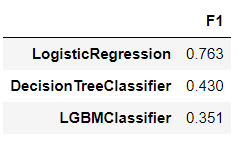

Очевидно, единственная модель, которая нам подходит - модель логистической регрессии. Проверим модель на тестовой выборке.

PS: Картинка с результатами моделей на случай, если не захочется тратить кучу времени на их обучение =)

In [22]:
#Проверяем модель логистической регрессии на тестовой выборке
predictions_lr = random_lr.best_estimator_.predict(features_test_vectorized)
f1_score(target_test, predictions_lr)

0.76760072494075

**Вывод:**
Наша модель логистической регрессии справилась с тестовой выборкой и набрала значение F1-меры в 0.767, тогда как по условию проекта от нас требовалось получить значение F1-меры не менее 0.75. Таким образом, мы выполнили поставленную задачу, с чем я нас и поздравляю!